# Minería de Datos: Preprocesamiento y Clasificación - DATCOM - 23/24

## Algoritmo Support Vector Machines (SVM)

In [1]:
import sklearn
import numpy as np
import pandas as pd

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy as sp
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import LocalOutlierFactor

# No mostrar warnings de versiones anteriores
import warnings
warnings.filterwarnings('ignore')

Probamos el algoritmo con los datos tan solo modificando algunos registros de las variables para poder aplicar el algoritmo y comprobar como se comporta este. Evidentemente debemos de realizar un preprocesamiento adecuado para no llegar una conclusión equivocada. 

In [2]:
# import pandas as pd
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

Realizamos una codificación de los datos de test y train para no tener problemas.

In [3]:
# X24 -> Factor ordenado (VLOW, LOW, MED, HIGH, VHIGH) -> LabelEncoder
# X25 -> Binario (YES, NO) -> LabelEncoder NO -> 0, YES -> 1. (Da un poco igual si es 0,1 o 1,2 la verdad)
# X30 -> ASKVR, CLPXZ, GXZVX, KUHMP, VTKGN, XNHTQ -> OneHotEncoder

# Ninguna presenta nulos, aplicamos las transformaciones y posteriormente imputación de NAs
# ------------------------------------------------------------------------------------------------------

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])

In [4]:
df_train_encoded_1 = df_train_encoded.dropna()
y_train = df_train_encoded_1["RATE"]
x_train = df_train_encoded_1.drop(["RATE"],axis=1, inplace=False)

print("Tamaño de los datos de entrenamiento: ", x_train.shape)
print("Tamaño de las etiquetas de entrenamiento: ", y_train.shape)

Tamaño de los datos de entrenamiento:  (561, 40)
Tamaño de las etiquetas de entrenamiento:  (561,)


In [5]:
y_train = df_train_encoded_1["RATE"].dropna(axis=0, inplace=False)
x_train = df_train_encoded_1.drop(["RATE"],axis=1, inplace=False).dropna(axis=0, inplace=False)

# Escalamos los datos
# x_train = StandardScaler().fit_transform(x_train)
# x_test = StandardScaler().fit_transform(x_test)

# Dividimos el conjunto de datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Reducimos dimensionalidad
# pca = PCA(n_components=2)
# x_train = pca.fit_transform(x_train)
# x_test = pca.fit_transform(x_test)

# Entrenamos el modelo
model = SVC()
model.fit(x_train, y_train)

# Predecimos
y_pred = model.predict(x_test)

# Evaluamos
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='macro'))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confusion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy:  0.40707964601769914
F1 score:  0.21336405529953917
Precision:  0.3490990990990991
Recall:  0.2916666666666667

 clasification report:
               precision    recall  f1-score   support

           A       1.00      0.17      0.29        12
           B       0.40      1.00      0.57        44
           C       0.00      0.00      0.00        29
           D       0.00      0.00      0.00        28

    accuracy                           0.41       113
   macro avg       0.35      0.29      0.21       113
weighted avg       0.26      0.41      0.25       113


 confusion matrix:
 [[ 2 10  0  0]
 [ 0 44  0  0]
 [ 0 29  0  0]
 [ 0 28  0  0]]


### Imputación de Missing Values (Imputación con KNN)

In [6]:
# Imputando con KNN (TRAIN)

train_id = df_train_encoded["ID"]
train_labels = df_train_encoded['RATE']
train_data = df_train_encoded.drop(['RATE', 'ID'], axis=1, inplace=False)

Knn_imp_train = KNNImputer(n_neighbors=4).fit(train_data)
imputed_X_train = pd.DataFrame(Knn_imp_train.transform(train_data), columns=train_data.columns)

result_df_train = train_id.to_frame().join(other=[imputed_X_train, train_labels])

# Imputando con KNN (TEST)

test_id = df_test_encoded["ID"]
test_data = df_test_encoded.drop(['ID'], axis=1, inplace=False)

imputed_X_test = pd.DataFrame(Knn_imp_train.transform(test_data), columns=test_data.columns)

result_df_test = test_id.to_frame().join(other=imputed_X_test)

### Exportación a carpeta de Preprocesamiento

In [7]:
 # Conversión de aquellas que eran enteros a enteros tras imputación knn
result_df_train['ID'] = result_df_train['ID'].astype('int')
result_df_train['X1'] = result_df_train['X1'].astype('int')
result_df_train['X2'] = result_df_train['X2'].astype('int')
result_df_train['X3'] = result_df_train['X3'].astype('int')
result_df_train['X5'] = result_df_train['X5'].astype('int')
result_df_train['X7'] = result_df_train['X7'].astype('int')
result_df_train['X24'] = result_df_train['X24'].astype('int')
result_df_train['X25'] = result_df_train['X25'].astype('int')
result_df_train['X30'] = result_df_train['X30'].astype('int')

result_df_test['ID'] = result_df_test['ID'].astype('int')
result_df_test['X1'] = result_df_test['X1'].astype('int')
result_df_test['X2'] = result_df_test['X2'].astype('int')
result_df_test['X3'] = result_df_test['X3'].astype('int')
result_df_test['X5'] = result_df_test['X5'].astype('int')
result_df_test['X7'] = result_df_test['X7'].astype('int')
result_df_test['X24'] = result_df_test['X24'].astype('int')
result_df_test['X25'] = result_df_test['X25'].astype('int')
result_df_test['X30'] = result_df_test['X30'].astype('int')

result_df_train.to_csv('../data_preprocess/train_preprocess.csv', index=False)
result_df_test.to_csv('../data_preprocess/test_preprocess.csv', index=False)

### Funciones de imputación, reescalado y outliers

In [11]:
def imp_escala_KNN(n_vecinos, df_train, df_test, escalar=True, tipo_scaler='minmax'):
  
  # Preprocesamiento para TRAIN
  df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
  train_ID = df_train['ID'].copy()
  train_RATE = df_train['RATE'].copy()
  
  # Preprocesamiento para TEST
  df_final_test = df_test.drop('ID', axis=1, inplace=False)
  test_ID = df_test['ID'].copy()

  if(escalar):
    if(tipo_scaler == 'minmax'):
      scaler = MinMaxScaler()
    elif(tipo_scaler == 'standar'):
      scaler = StandardScaler()
    else:
      scaler = MinMaxScaler()
    
    df_scaled = scaler.fit_transform(df_final_train.to_numpy())
    df_scaled = pd.DataFrame(df_scaled,index=df_final_train.index, columns=[df_final_train.columns])

    df_scaled_test = scaler.transform(df_final_test.to_numpy())
    df_scaled_test = pd.DataFrame(df_scaled_test,index=df_final_test.index, columns=[df_final_test.columns])

  else:
    df_scaled = df_final_train
    df_scaled_test = df_final_test
  
  Knn_imp_train = KNNImputer(n_neighbors=n_vecinos).fit(df_scaled)
  imputed_X_train = pd.DataFrame(Knn_imp_train.transform(df_scaled), columns=df_scaled.columns)

  Knn_imp_test = KNNImputer(n_neighbors=n_vecinos).fit(df_scaled_test)
  imputed_X_test = pd.DataFrame(Knn_imp_test.transform(df_scaled_test), columns=df_scaled_test.columns)

  columns = ['ID']
  columns = np.append(columns, df_final_train.columns)
  columns = np.append(columns, 'RATE')

  result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
  result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
  result_df_train.columns = columns

  columns = ['ID']
  columns = np.append(columns, df_final_test.columns)
  
  result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
  result_df_test.columns = columns

  return result_df_train, result_df_test

In [8]:
def imp_escala_Median(df_train, df_test, escalar=True, tipo_scaler='minmax'):
  
  # Preprocesamiento para TRAIN
  df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
  train_ID = df_train['ID'].copy()
  train_RATE = df_train['RATE'].copy()
  
  # Preprocesamiento para TEST
  df_final_test = df_test.drop('ID', axis=1, inplace=False)
  test_ID = df_test['ID'].copy()

  if(escalar):
    if(tipo_scaler == 'minmax'):
      scaler = MinMaxScaler()
    elif(tipo_scaler == 'standar'):
      scaler = StandardScaler()
    else:
      scaler = MinMaxScaler()
    
    df_scaled = scaler.fit_transform(df_final_train.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, index=df_final_train.index, columns=df_final_train.columns)

    df_scaled_test = scaler.transform(df_final_test.to_numpy())
    df_scaled_test = pd.DataFrame(df_scaled_test, index=df_final_test.index, columns=df_final_test.columns)

  else:
    df_scaled = df_final_train
    df_scaled_test = df_final_test
  
  # Impute missing values using SimpleImputer with median
  imputer = SimpleImputer(strategy='median')
  imputed_X_train = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_scaled.columns)

  imputed_X_test = pd.DataFrame(imputer.transform(df_scaled_test), columns=df_scaled_test.columns)

  columns = ['ID']
  columns = np.append(columns, df_final_train.columns)
  columns = np.append(columns, 'RATE')

  result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
  result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
  result_df_train.columns = columns

  columns = ['ID']
  columns = np.append(columns, df_final_test.columns)
  
  result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
  result_df_test.columns = columns

  return result_df_train, result_df_test

In [9]:
def detect_outliers(df, escalar=True):
  
  # Neceistamos ID, RATE por separado, para escalar y quitar outliers sin que influyan estos parámetros 
  df_train_no_target = df.drop(['ID','RATE'], inplace=False, axis=1).dropna(axis=0, inplace=False)

  if(escalar):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_train_no_target.to_numpy())
    df_scaled = pd.DataFrame(df_scaled,index=df_train_no_target.index, columns=[df_train_no_target.columns])
  else:
    df_scaled = df_train_no_target

  lof = LocalOutlierFactor()
  y_pred = lof.fit_predict(df_scaled)
  X_scores = lof.negative_outlier_factor_

  iqr = np.quantile(X_scores, 0.75) - np.quantile(X_scores, 0.25)

  #print("The LOF error score has an IQR of {:.4f}".format(iqr))

  cutoff_value = np.quantile(X_scores, 0.25) - (1.5 * iqr)

  #print("The cutouff value to remove outliers using LOF is {:.4f}".format(cutoff_value))

  # Sacamos los índices de los outliers
  df_outliers = df_scaled[X_scores <= cutoff_value]

  # Quitamos estos índices al df encoded.
  df_result = df.drop(df_outliers.index, axis=0, inplace=False)
  
  return df_result

### Pruebas de modelos

#### 1ª Prueba (Más tarde)

Modelo:
- Sin quitar outliers y con encoder
- Imputando con KNNImputer (n_neighbors = 4)

In [7]:
y = result_df_train["RATE"]
X = result_df_train.drop(["ID","RATE"],axis=1, inplace=False)

print("Tamaño de los datos de entrenamiento: ", X.shape)
print("Tamaño de las etiquetas de entrenamiento: ", y.shape)


Tamaño de los datos de entrenamiento:  (906, 39)
Tamaño de las etiquetas de entrenamiento:  (906,)


In [8]:
# Dividimos el conjunto de datos en train y test 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}

np.random.seed(1234)

SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(SVCM_grid.best_params_)
print(SVCM_grid.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


In [ ]:
y_pred = SVCM_grid.predict(x_test)
print("Informe completo con búsqueda exhaustiva de parámetros\n",classification_report(y_test, y_pred))

In [26]:
# Dividimos el conjunto de datos en train y test 70/30
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}

np.random.seed(1234)

SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(x_train, y_train)

print(SVCM_grid.best_params_)
print(SVCM_grid.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.41274509803921566


In [27]:
y_pred = SVCM_grid.predict(x_test)
print("Informe completo con búsqueda exhaustiva de parámetros\n",classification_report(y_test, y_pred))

Informe completo con búsqueda exhaustiva de parámetros
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        20
           B       0.45      1.00      0.62       115
           C       0.00      0.00      0.00        60
           D       0.00      0.00      0.00        61

    accuracy                           0.45       256
   macro avg       0.11      0.25      0.15       256
weighted avg       0.20      0.45      0.28       256



#### 2ª Prueba

Modelo:

- Imputando con KNN (K = X) y datos escalados (MinMax)

In [12]:
for i in np.arange(1,20):
    result_df_train, result_df_test = imp_escala_KNN(i,df_train_encoded, df_test_encoded, True)
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

    np.random.seed(1234)
    
    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train, y_train)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
    
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=10, gamma=0.1)
Acc en GridSearch 0.6481939757530308
Acc. en Validación: 0.6360294117647058


Matriz de confusión:
[[ 3 12  2  0]
 [ 3 96 18  5]
 [ 0 24 23 14]
 [ 0  5 16 51]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.18      0.26        17
           B       0.70      0.79      0.74       122
           C       0.39      0.38      0.38        61
           D       0.73      0.71      0.72        72

    accuracy                           0.64       272
   macro avg       0.58      0.51      0.53       272
weighted avg       0.63      0.64      0.62       272

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=1000, gamma=0.1, kernel='linear')
Acc en Gr

#### 3ª Prueba

Modelo:
- Imputando con KNN (K = X) y datos escalados (Standar)

In [13]:
for i in np.arange(1,20):
    result_df_train, result_df_test = imp_escala_KNN(i,df_train_encoded, df_test_encoded, True, 'standar')
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

    np.random.seed(1234)
    
    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train, y_train)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
    
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=0.1, gamma=0.1, kernel='linear')
Acc en GridSearch 0.6529183852018499
Acc. en Validación: 0.625


Matriz de confusión:
[[ 4 12  1  0]
 [ 5 91 20  6]
 [ 0 24 24 13]
 [ 0  3 18 51]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.44      0.24      0.31        17
           B       0.70      0.75      0.72       122
           C       0.38      0.39      0.39        61
           D       0.73      0.71      0.72        72

    accuracy                           0.62       272
   macro avg       0.56      0.52      0.53       272
weighted avg       0.62      0.62      0.62       272

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=0.1, gamma=0.1, kernel='linear')
Acc e

#### 4ª Prueba

Modelo:
- Imputando con la mediana y datos escalados (MinMax)

In [14]:

result_df_train, result_df_test = imp_escala_Median(df_train_encoded, df_test_encoded, True)
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

np.random.seed(1234)
    
# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
    
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=10, gamma=0.1, kernel='linear')
Acc en GridSearch 0.6482189726284214
Acc. en Validación: 0.6360294117647058


Matriz de confusión:
[[ 4 13  0  0]
 [ 4 90 22  6]
 [ 0 22 26 13]
 [ 0  4 15 53]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.24      0.32        17
           B       0.70      0.74      0.72       122
           C       0.41      0.43      0.42        61
           D       0.74      0.74      0.74        72

    accuracy                           0.64       272
   macro avg       0.59      0.53      0.55       272
weighted avg       0.63      0.64      0.63       272



#### 5ª Prueba

Modelo:
- Imputando con la mediana y datos escalados (Standardscaler)

In [15]:
result_df_train, result_df_test = imp_escala_Median(df_train_encoded, df_test_encoded, True, 'standar')
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

np.random.seed(1234)
    
# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
    
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=100, gamma=0.1, kernel='linear')
Acc en GridSearch 0.6498062742157231
Acc. en Validación: 0.6360294117647058


Matriz de confusión:
[[11  6  0  0]
 [ 8 84 24  6]
 [ 1 20 28 12]
 [ 0  4 18 50]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.55      0.65      0.59        17
           B       0.74      0.69      0.71       122
           C       0.40      0.46      0.43        61
           D       0.74      0.69      0.71        72

    accuracy                           0.64       272
   macro avg       0.61      0.62      0.61       272
weighted avg       0.65      0.64      0.64       272



#### 6ª Prueba

Modelo:

- Quitando outliers
- Imputando con KNN (K = X) y datos escalados (MinMax)

In [13]:
for i in np.arange(1,20):
    df_sin_outliers = detect_outliers(df_train_encoded, True)
    result_df_train, result_df_test = imp_escala_KNN(i,df_sin_outliers, df_test_encoded, True)
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

    np.random.seed(1234)
    
    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train, y_train)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
    
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))
    

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=0.1, gamma=0.1)
Acc en GridSearch 0.4144257703081232
Acc. en Validación: 0.4453125


Matriz de confusión:
[[  0  13   0   0]
 [  0 114   0   0]
 [  0  59   0   0]
 [  0  70   0   0]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.45      1.00      0.62       114
           C       0.00      0.00      0.00        59
           D       0.00      0.00      0.00        70

    accuracy                           0.45       256
   macro avg       0.11      0.25      0.15       256
weighted avg       0.20      0.45      0.27       256

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=0.1, gamma=0.1)
Acc en GridSearch 0

#### 7ª Prueba

Modelo:

- Quitando outliers
- Imputando con la mediana y datos escalados (MinMax)

In [14]:
df_sin_outliers = detect_outliers(df_train_encoded, True)
result_df_train, result_df_test = imp_escala_Median(df_sin_outliers, df_test_encoded, True)
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

np.random.seed(1234)
    
# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
    
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=0.1, gamma=0.1)
Acc en GridSearch 0.4144257703081232
Acc. en Validación: 0.4453125


Matriz de confusión:
[[  0  13   0   0]
 [  0 114   0   0]
 [  0  59   0   0]
 [  0  70   0   0]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.45      1.00      0.62       114
           C       0.00      0.00      0.00        59
           D       0.00      0.00      0.00        70

    accuracy                           0.45       256
   macro avg       0.11      0.25      0.15       256
weighted avg       0.20      0.45      0.27       256



#### 8ª Prueba

Modelo:

- Sin quitar outliers
- Imputando con KNN (K = X) y datos escalados (MinMax)
- Aplicamos Over sampling, SMOTE

In [15]:
print(df_train_encoded.groupby(['RATE'])['RATE'].count())
print("\n")
print(df_train_encoded.shape)

RATE
A     74
B    386
C    232
D    214
Name: RATE, dtype: int64


(906, 41)


RATE
A     74
B    386
C    232
D    214
Name: RATE, dtype: int64


(906, 41)


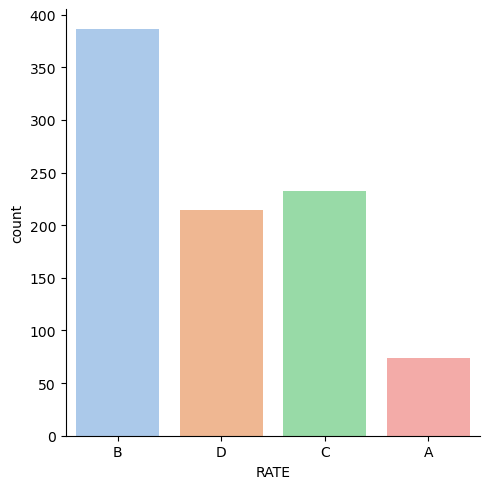

In [16]:
#1. Imputamos con k=5 y escalamos
result_df_train, result_df_test = imp_escala_KNN(5,df_train_encoded,df_test_encoded,True)

sns.catplot(data=result_df_train, x="RATE", kind="count", palette="pastel")

print(result_df_train.groupby(['RATE'])['RATE'].count())
print("\n")
print(result_df_train.shape)

[0.31761594 0.15025554]


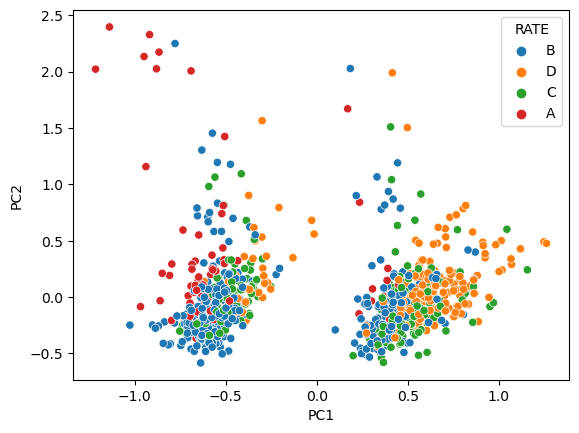

In [20]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

pca_df = pd.DataFrame(data=pca_features, columns =['PC1','PC2'])
print(pca.explained_variance_ratio_)

pca_df['RATE'] = result_df_train['RATE']

sns.scatterplot(data = pca_df,x="PC1",y="PC2", hue="RATE")
plt.show()

[0.33089996 0.2022744 ]


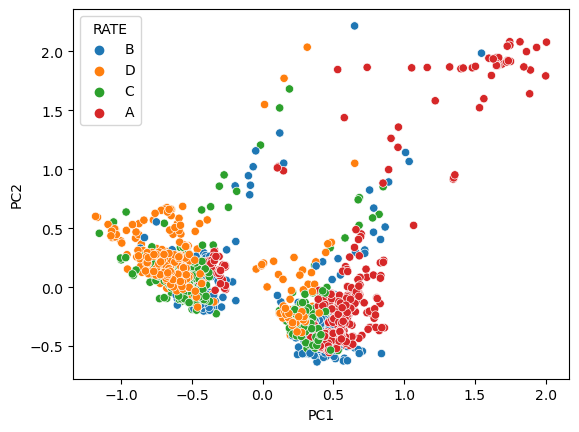

In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X, y)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_resampled)

pca_df = pd.DataFrame(data=pca_features, columns =['PC1','PC2'])
print(pca.explained_variance_ratio_)

pca_df['RATE'] = y_resampled

sns.scatterplot(data = pca_df,x="PC1",y="PC2", hue="RATE")
plt.show()

In [23]:
print(pca_df.groupby(['RATE'])['RATE'].count())
print("\n")
print(pca_df.shape)

RATE
A    386
B    386
C    386
D    386
Name: RATE, dtype: int64


(1544, 3)


In [29]:
for i in np.arange(1,20):
    
    result_df_train, result_df_test = imp_escala_KNN(i,df_train_encoded, df_test_encoded, True)
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 32, shuffle=True)
    X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

    np.random.seed(1234)

    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train_resampled, y_train_resampled)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
  
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n")
    print(f"Matriz de confusión:\n {confusion_matrix(y_test, y_pred)}\n\n")
    # print(confusion_matrix(y_test, y_pred)"\n\n")
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=10, gamma=10)
Acc en GridSearch 0.8193654524089306
Acc. en Validación: 0.4931129476584022

Matriz de confusión:
 [[  3  28   0   1]
 [  2 130  18   5]
 [  0  53  14  19]
 [  0  41  17  32]]


Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.60      0.09      0.16        32
           B       0.52      0.84      0.64       155
           C       0.29      0.16      0.21        86
           D       0.56      0.36      0.44        90

    accuracy                           0.49       363
   macro avg       0.49      0.36      0.36       363
weighted avg       0.48      0.49      0.44       363

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=10, gamma=10)
Acc en GridS

#### 9ª Prueba 

Modelo:
- Sin quitar outliers
- Imputando con la mediana y datos escalados (MinMax)
- Aplicamos Over sampling, SMOTE

In [30]:
result_df_train, result_df_test = imp_escala_Median(df_train_encoded, df_test_encoded, True)
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

np.random.seed(1234)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train_resampled, y_train_resampled)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
  
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n")
print(f"Matriz de confusión:\n {confusion_matrix(y_test, y_pred)}\n\n")
# print(confusion_matrix(y_test, y_pred)"\n\n")
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 19: Número de vecinos al imputar con KNNImputer: 19
Mejores parámetros SVC(C=100, gamma=1)
Acc en GridSearch 0.833385495841903
Acc. en Validación: 0.5661764705882353

Matriz de confusión:
 [[12  3  2  0]
 [12 71 32  7]
 [ 0 25 27  9]
 [ 0  9 19 44]]


Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.71      0.59        17
           B       0.66      0.58      0.62       122
           C       0.34      0.44      0.38        61
           D       0.73      0.61      0.67        72

    accuracy                           0.57       272
   macro avg       0.56      0.59      0.56       272
weighted avg       0.60      0.57      0.58       272



#### 10ª prueba

Modelo:
- Sin quitar outliers
- Imputando con la mediana y datos escalados (MinMax)
- Aplicando Over sampling, SMOTE
- OVO y OVA

In [38]:
from sklearn.multiclass import OneVsOneClassifier

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

np.random.seed(1234)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
ovo = OneVsOneClassifier(SVCM_grid)
ovo.fit(X_train_resampled, y_train_resampled)

y_pred = ovo.predict(X_test)
print("Informe completo para OVO wrapper\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Informe completo para OVO wrapper
               precision    recall  f1-score   support

           A       0.50      0.12      0.19        17
           B       0.70      0.66      0.68       122
           C       0.36      0.52      0.43        61
           D       0.69      0.61      0.65        72

    accuracy                           0.58       272
   macro avg       0.56      0.48      0.48       272
weighted avg       0.61      0.58      0.58       272



In [35]:
from sklearn.multiclass import OneVsRestClassifier

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

np.random.seed(1234)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
ova = OneVsRestClassifier(SVCM_grid)
ova.fit(X_train_resampled, y_train_resampled)

y_pred = ova.predict(X_test)
print("Informe completo para OVA wrapper\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Informe completo para OVA wrapper
               precision    recall  f1-score   support

           A       0.50      0.29      0.37        17
           B       0.65      0.69      0.67       122
           C       0.32      0.36      0.34        61
           D       0.71      0.62      0.67        72

    accuracy                           0.57       272
   macro avg       0.54      0.49      0.51       272
weighted avg       0.58      0.57      0.57       272



#### 11ª prueba

Modelo:
- Realizando un nuevo preprocesamiento
- Sin quitar outliers
- Imputando con knn y escalando con StandardScaler

# Resultados para Kaggle

In [44]:
# VALIDAR EL MEJOR MODELO CON LOS DATOS DE TEST Y GENERAR CSV PARA KAGGLE

X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

# X_final_validacion = X_final_validacion[['X15','X21','X16','X22','X18','X17','X1','X11','X4','X27','X35','X37','X23']].copy()

y_pred = ovo.predict(X_final)
y_pred_df = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

# print("Matriz de confusión:")
# print(confusion_matrix(y_validacion, y_pred))
# print(f"Acc. en Validación: {accuracy_score(y_validacion, y_pred)}\n\n")
y_pred_df

y_pred_df.to_csv('../Resultados/prediccion.csv', index=False, sep=',')